In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from plotter import *
from easyesn.optimizers import GradientOptimizer
from easyesn import PredictionESN
from easyesn import BaseESN
# note: you must make this change in the easyesn code
# https://github.com/kalekiu/easyesn/issues/12
from easyesn.optimizers import GridSearchOptimizer
from easyesn import helper as hlp


""" NOTES:
    This file provides mechanisms to:
    A) Data Processing
        1) Load trajectories from csv files ( file must contain columns 'x', 'y')
        2) Create a trajectory from a trajectory generator (see more documentation in respective function)
        3) Load a generator from a csv file
        4) Load a set of feeders from a csv file
        5) Generate a matrix of place cell activations (row=place cell, column=time_index) 
           pc activation computed according to following formula:
                 e^( log(K) * ||pos - pc_center||^2 / r^2  )
           where 
                r is the place cell's radius
                K is the place cell's activation value at the radius
    
    B) Plot data
        Imports functionalities from 'plotter.py' which uses library matplotlib
"""


# CONSTANTS
PC_VALUE_AT_RADIUS = 0.8 # 0.3  # 0.2 activation value (constant K in pc activation formula)


def load_path(file_name):
    """" load csv fle specifying a path
         file must contain at least columns 'x' and 'y'
    """
    return pd.read_csv(file_name, delim_whitespace=True)
    # return sequence[['x', 'y']].to_numpy()


def load_generator(file_name):
    """" load csv fle specifying a path generator
             file must contain at least columns 'x', 'y' and 'steps'
        """
    return pd.read_csv(file_name, delim_whitespace=True)


def generate_path(generator):
    """ Generate a path using a generator
        'generator' is a pandas data frame containing at least 3 columns 'x' 'y' and 'steps'
        Column 'steps' indicate the number of step to reach the following way point (the
        value in the last row is ignored since it is the last point in the path)
    """

    # convert data to numpy arrays
    xy = generator[['x', 'y']].to_numpy()  # waypoints
    steps = generator['steps'].to_numpy()  #

    # interpolate each segment
    # endpoint=False will avoid repeating the last coordinate of each segment
    interpolator = lambda m_tuple: np.linspace(*m_tuple, endpoint=False)
    data = zip(xy[:-1], xy[1:], steps[:-1])
    path = np.concatenate(list(map(interpolator, data)) + [[xy[-1]]])
    return pd.DataFrame(path, columns=['x', 'y'])


def load_feeders(file_name):
    """"Function to load a set of feeders"""
    return pd.read_csv(file_name, delim_whitespace=True)[['x', 'y']]


def load_place_cells(file_name):
    """" Load csv fle specifying a set of place cells
         file must contain at least columns 'x', 'y' and 'placeradius'
    """
    return pd.read_csv(file_name, delim_whitespace=True)
    # return pcs[['x', 'y']].to_numpy(), pcs['placeradius'].to_numpy()


def calc_activation_matrix(path, pcs):
    """ Calculate a matrix containing the activation of all place cells for all times.
        Each row represents a place cell, while columns represent the time index.
        Both 'pos' and 'pcs' are data frames containing the path and the set of place cells.
    """
    # get number of pcs and position in path
    num_pcs = len(pcs)
    num_pos = len(path)

    # convert data to numpy to operate
    radii = pcs['placeradius'].to_numpy()
    pcs = pcs[['x', 'y']].to_numpy()
    pos = path[['x', 'y']].to_numpy()

    # replicate the position vector by the number of place cells for easy operations
    pos_tile = pos.reshape(1, -1, 2)
    pos_all = np.tile(pos_tile, (num_pcs, 1, 1))

    # replicate the place cells and radii by the number of positions for easy operations
    pcs_tile = pcs.reshape(-1, 1, 2)
    pcs_all = np.tile(pcs_tile, (1, num_pos, 1))
    radii_all = np.tile(radii.reshape((-1, 1)), (1, num_pos))

    # calculate the activations (see description of formula at the top of this file)
    delta = pos_all - pcs_all
    delta2 = (delta * delta).sum(2)
    r2 = radii_all * radii_all
    exponents = np.log(PC_VALUE_AT_RADIUS) * delta2 / r2
    activations = np.exp(exponents)
    return activations







Using Numpy backend.


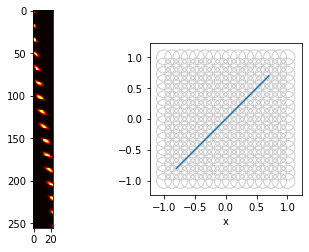

In [2]:
    # test load place cells and a trajectory
    pcs = load_place_cells('input/placecells.csv')
    abcde = load_path('input/abcde.csv')
    feeders = load_feeders('input/feeders.csv')

    # test load generator and generate path using 'sample_path_generator.csv':
    # the generator is a sequence of way points
    # 'steps' indicate the number of steps to reach the next way point
    # note: the number of steps in the last row is ignored
    #   x     |  y     | steps
    # ------------------------
    #   -0.4  |  -0.4  |   7
    #    0    |   0    |  10
    #    0.5  |   0    |  -1

    # note: alternatively you can generate the data like this:
    # sample_generator = pd.DataFrame({'x':     [-0.4,  0,  0.5],
    #                                  'y':     [-0.4,  0,  0  ],
    #                                  'steps': [ 7  , 10, -1  ]})
    
    #modifying to allow two sequences
#    sample_generator = load_generator('input/sample_path_generator.csv')
#    sample_generator2 = load_generator('input/sample_path_generator2.csv')
    sample_generator = load_generator('input/syn-fss')
    sample_generator2 = load_generator('input/syn-sfs')
    sample_generator3 = load_generator('input/syn-mmm')
    generated_path = generate_path(sample_generator)
    generated_path2 = generate_path(sample_generator2)
    generated_path3 = generate_path(sample_generator3)

    # test calculation of activation matrix
    # choose sequence: 'generated_path' or 'abcde'
    sequence = generated_path
    activations = calc_activation_matrix(sequence, pcs)
    sequence2 = generated_path2
    activations2 = calc_activation_matrix(sequence2, pcs)
    sequence3 = generated_path3
    activations3 = calc_activation_matrix(sequence3, pcs)    

    # test plot utilities
    fig, axs = plt.subplots(1, 2 )
    f1 = axs[0]
    f2 = axs[1]
    f2.autoscale(enable=True)
    f2.set_aspect('equal')
    plot_activation_matrix_heatmap(activations, plot=f1)

    plot_place_cells(pcs, plot=f2)  # add place cells to figure
#    plot_maze(plot=f2)
    plot_path(sequence, plot=f2)
#    plot_feeders(feeders, plot=f2, s=80, zorder=2)  # zorder can be used to move the layer up or down
    plt.savefig('reservoirstates-Y-left.png', dpi = 1200)
    plt.show()



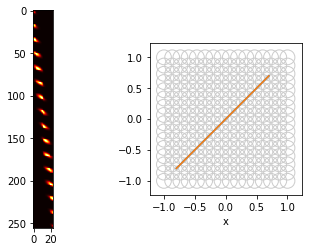

In [3]:
    # test plot utilities
    fig, axs = plt.subplots(1, 2 )
    f1 = axs[0]
    f2 = axs[1]
    f2.autoscale(enable=True)
    f2.set_aspect('equal')
    plot_activation_matrix_heatmap(activations2, plot=f1)

    plot_place_cells(pcs, plot=f2)  # add place cells to figure
#    plot_maze(plot=f2)
    plot_path(sequence, plot=f2)
    plot_path(sequence2, plot=f2)
#    plot_feeders(feeders, plot=f2, s=80, zorder=2)  # zorder can be used to move the layer up or down

    plt.savefig('reservoirstates-Y-right.png')
    plt.show()



In [4]:
np.random.seed(1)
vectorDim = 256
numNode = 400
print(activations.shape)
inputDataTraining = activations.T
outputDataTraining = activations.T
print(inputDataTraining.shape)

(256, 23)
(23, 256)


In [5]:
for num in range(10):
    inputDataTraining = np.append(inputDataTraining, inputDataTraining, axis=0)
print(inputDataTraining.shape)
outputDataTraining=inputDataTraining

(23552, 256)


In [6]:
esn = PredictionESN(n_input=vectorDim, n_output=vectorDim, n_reservoir=numNode, leakingRate=0.05, regressionParameters=[1e-2], solver="lsqr", feedback=False)

In [7]:
esn.fit(inputDataTraining, outputDataTraining, transientTime="Auto", verbose=1)

100% (23133 of 23133) |##################| Elapsed Time: 0:00:01 Time:  0:00:01


1.2006749375014141e-05

In [8]:
print(PC_VALUE_AT_RADIUS)

0.8


In [9]:
inputDataTesting = activations.T
inputDataTesting2 = activations2.T
inputDataTesting3 = activations3.T
print(len(inputDataTesting))
print(len(inputDataTesting2))
print(len(inputDataTesting3))

23
23
23


In [10]:
reservoirStatesBuffer = np.empty((0,numNode))
prediction,reservoirStatesBuffer  = esn.predict(inputDataTesting)
reservoirStatesBuffer = reservoirStatesBuffer.T
reservoirStatesBuffer = reservoirStatesBuffer[:,257:]
print(reservoirStatesBuffer.shape)
print(prediction.shape)

(23, 400)
(23, 256)


In [11]:
reservoirStatesBuffer2 = np.empty((0,numNode))
prediction,reservoirStatesBuffer2  = esn.predict(inputDataTesting2)
reservoirStatesBuffer2 = reservoirStatesBuffer2.T
reservoirStatesBuffer2 = reservoirStatesBuffer2[:,257:]
print(reservoirStatesBuffer2.shape)
print(prediction.shape)

(23, 400)
(23, 256)


In [12]:
reservoirStatesBuffer3 = np.empty((0,numNode))
prediction,reservoirStatesBuffer3  = esn.predict(inputDataTesting3)
reservoirStatesBuffer3 = reservoirStatesBuffer3.T
reservoirStatesBuffer3 = reservoirStatesBuffer3[:,257:]
print(reservoirStatesBuffer3.shape)
print(prediction.shape)

(23, 400)
(23, 256)


In [13]:
vectordim=256
past = .95
present = 1.05

inputAverageTesting1 = np.zeros((len(inputDataTesting),vectorDim))
inputAverageTesting2 = np.zeros((len(inputDataTesting2),vectorDim))
inputAverageTesting3 = np.zeros((len(inputDataTesting3),vectorDim))

print(inputAverageTesting1.shape)

for num in range(len(inputDataTesting)):
        if num == 0:
            inputAverageTesting1[num] = inputDataTesting[num]
            inputAverageTesting2[num] = inputDataTesting2[num]
            inputAverageTesting3[num] = inputDataTesting3[num]
        else:
            inputAverageTesting1[num] = past*inputAverageTesting1[num-1] + present*inputDataTesting[num] 
            inputAverageTesting2[num] = past*inputAverageTesting2[num-1] + present*inputDataTesting2[num] 
            inputAverageTesting3[num] = past*inputAverageTesting3[num-1] + present*inputDataTesting3[num] 


(23, 256)


In [14]:

data = np.empty((len(inputDataTesting)))
data2 = np.empty((len(inputDataTesting)))

# simplify - dont need the whole trajectory, just for the final 
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

for num in range(len(inputDataTesting)):
    data[num] = cos_sim(reservoirStatesBuffer[num],reservoirStatesBuffer2[num])
    #data2[num] = np.power(cos_sim(inputDataTestingA[num],inputDataTestingB[num]),3)
    data2[num] = cos_sim(inputDataTesting[num],inputDataTesting2[num])

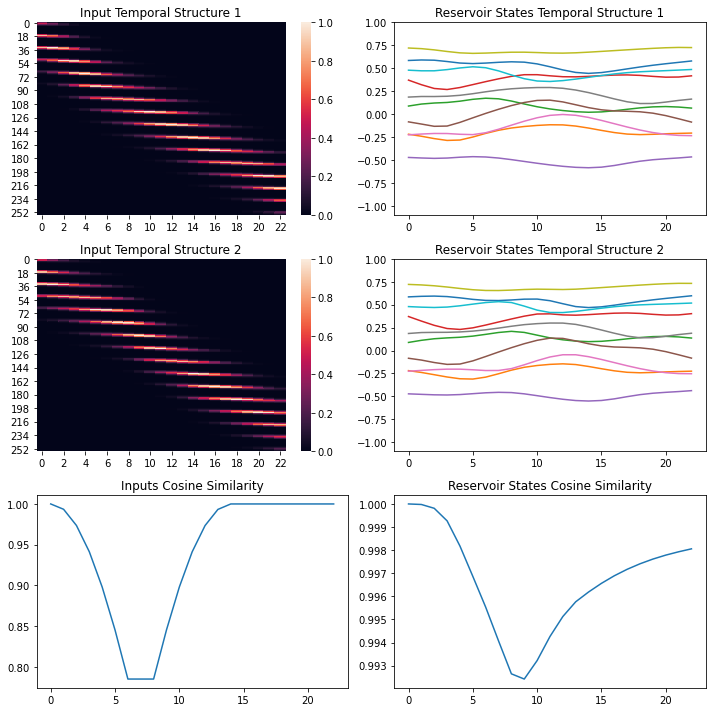

In [15]:
resn = 10
fig= plt.figure(figsize=(10,10))
#fig.suptitle('State Trajectories', fontsize=16)
#fig.suptitle('State Trajectories')

plt.subplot(321)

#plt.plot( inputDataTesting[:76,:])
#sns.heatmap(activations, cmap="seismic")
sns.heatmap(activations)

#plt.ylim([-1.1,1])
plt.title('Input Temporal Structure 1')

plt.subplot(323)

#plt.plot( inputDataTesting2[:76,:])
#sns.heatmap(activations2, vmin=0.4, vmax=1)
sns.heatmap(activations2)


#plt.ylim([-1.1,1])
plt.title('Input Temporal Structure 2')

plt.subplot(325)
plt.plot( data2)
#plt.ylim([-0.1,0.1])
plt.title('Inputs Cosine Similarity')

plt.subplot(322)
plt.plot( reservoirStatesBuffer[:,:resn])
#plt.plot( inputDataTestingA[:,:5])

plt.ylim([-1.1,1])
plt.title('Reservoir States Temporal Structure 1')

plt.subplot(324)
plt.plot( reservoirStatesBuffer2[:,:resn])
#plt.plot( inputDataTestingB[:,:5])


plt.ylim([-1.1,1])
plt.title('Reservoir States Temporal Structure 2')

plt.subplot(326)
plt.plot( data)
#plt.ylim([-0.1,0.1])
plt.title('Reservoir States Cosine Similarity')

fig.tight_layout()

plt.savefig('reservoirstates-Y-simplified.png')

In [16]:
#here we replace reservoir with integrator
data = np.empty((len(inputDataTesting)))
data2 = np.empty((len(inputDataTesting)))

# simplify - dont need the whole trajectory, just for the final 
def cos_sim(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

for num in range(len(inputDataTesting)):
    data[num] = cos_sim(inputAverageTesting1[num],inputAverageTesting2[num])
    #data2[num] = np.power(cos_sim(inputDataTestingA[num],inputDataTestingB[num]),3)
    data2[num] = cos_sim(inputDataTesting[num],inputDataTesting2[num])

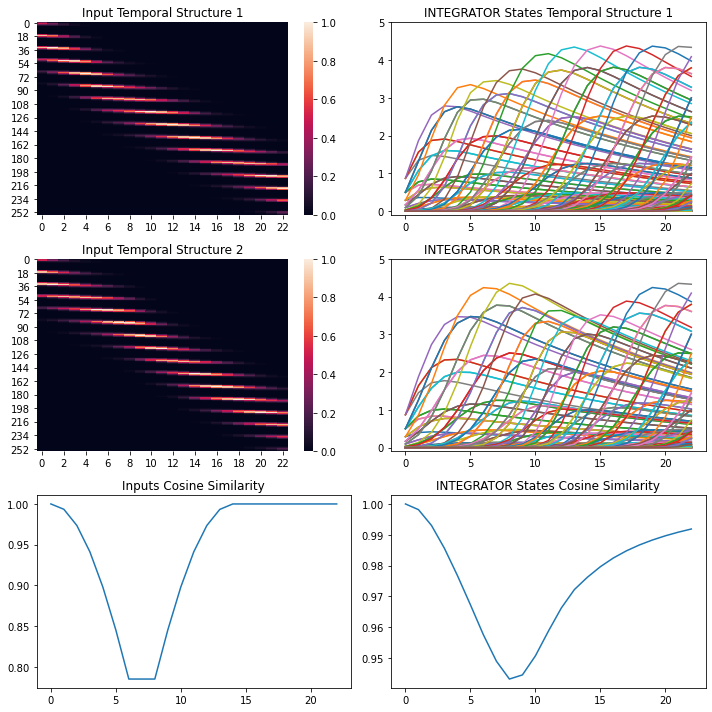

In [17]:
resn = 256
fig= plt.figure(figsize=(10,10))
#fig.suptitle('State Trajectories', fontsize=16)
#fig.suptitle('State Trajectories')

plt.subplot(321)

#plt.plot( inputDataTesting[:76,:])
#sns.heatmap(activations, cmap="seismic")
sns.heatmap(activations)

#plt.ylim([-1.1,1])
plt.title('Input Temporal Structure 1')

plt.subplot(323)

#plt.plot( inputDataTesting2[:76,:])
#sns.heatmap(activations2, vmin=0.4, vmax=1)
sns.heatmap(activations2)


#plt.ylim([-1.1,1])
plt.title('Input Temporal Structure 2')

plt.subplot(325)
plt.plot( data2)
#plt.ylim([-0.1,0.1])
plt.title('Inputs Cosine Similarity')

plt.subplot(322)
plt.plot( inputAverageTesting1[:,:resn])
#plt.plot( inputDataTestingA[:,:5])

plt.ylim([-0.1,5])
plt.title('INTEGRATOR States Temporal Structure 1')

plt.subplot(324)
plt.plot( inputAverageTesting2[:,:resn])
#plt.plot( inputDataTestingB[:,:5])


plt.ylim([-0.1,5])
plt.title('INTEGRATOR States Temporal Structure 2')

plt.subplot(326)
plt.plot( data)
#plt.ylim([-0.1,0.1])
plt.title('INTEGRATOR States Cosine Similarity')

fig.tight_layout()

plt.savefig('SEQUENCE-robot-LI.png')

In [18]:
stat_data=np.zeros((400,18))

In [19]:
print(len(reservoirStatesBuffer2[1]))

400


In [20]:
#OK NOW WE FORMAT THE DATA TO GO INTO THE ANOVA
# 8 6 8
# 4 11 18
#6 8 8
#3 10 18
# 7 7 8
# 
#create stats table: three columns
early = 4#5#8 #7
middle = 11#11#13#15
late = 18#16#15
delta=1
for i in range(len(reservoirStatesBuffer2[1])):
    #12 columns: 2x2x3 type, rep, 5, 13, 21 for 'fss_0', 'fss_1', 'sfs_0', 'sfs_1'
    stat_data[i,0]=reservoirStatesBuffer[early,i]
    stat_data[i,1]=reservoirStatesBuffer[middle,i]    
    stat_data[i,2]=reservoirStatesBuffer[late,i]        
    stat_data[i,3]=reservoirStatesBuffer[early+delta,i]
    stat_data[i,4]=reservoirStatesBuffer[middle+delta,i]    
    stat_data[i,5]=reservoirStatesBuffer[late+delta,i]            

    stat_data[i,6]=reservoirStatesBuffer2[early,i]
    stat_data[i,7]=reservoirStatesBuffer2[middle,i]    
    stat_data[i,8]=reservoirStatesBuffer2[late,i]        
    stat_data[i,9]=reservoirStatesBuffer2[early+delta,i]
    stat_data[i,10]=reservoirStatesBuffer2[middle+delta,i]    
    stat_data[i,11]=reservoirStatesBuffer2[late+delta,i]      
    
    stat_data[i,12]=reservoirStatesBuffer3[early,i]
    stat_data[i,13]=reservoirStatesBuffer3[middle,i]    
    stat_data[i,14]=reservoirStatesBuffer3[late,i]        
    stat_data[i,15]=reservoirStatesBuffer3[early+delta,i]
    stat_data[i,16]=reservoirStatesBuffer3[middle+delta,i]    
    stat_data[i,17]=reservoirStatesBuffer3[late+delta,i]          

In [21]:
import pandas as pd
import numpy as np
# load data file
df=pd.read_excel("test-data-template-3seq.xlsx")
print(df)

   subject position sequence   valye speed
0       s1      ear      fss  0.3599  fast
1       s1      mid      fss  0.3975  slow
2       s1     late      fss  0.3278  slow
3       s2      ear      fss  0.2908  fast
4       s2      mid      fss  0.2844  slow
5       s2     late      fss  0.2907  slow
6       s1      ear      sfs  0.3724  slow
7       s1      mid      sfs  0.3582  fast
8       s1     late      sfs  0.2207  slow
9       s2      ear      sfs  0.2460  slow
10      s2      mid      sfs  0.3044  fast
11      s2     late      sfs  0.2779  slow
12      s1      ear      mmm  0.3724   med
13      s1      mid      mmm  0.3582   med
14      s1     late      mmm  0.2207   med
15      s2      ear      mmm  0.2460   med
16      s2      mid      mmm  0.3044   med
17      s2     late      mmm  0.2779   med


In [22]:
neuron = 50
for i in range(18):
    df.loc[i,'valye']=stat_data[neuron,i]

In [23]:
print(df)

   subject position sequence     valye speed
0       s1      ear      fss  0.433574  fast
1       s1      mid      fss  0.460372  slow
2       s1     late      fss  0.509907  slow
3       s2      ear      fss  0.455825  fast
4       s2      mid      fss  0.478280  slow
5       s2     late      fss  0.463471  slow
6       s1      ear      sfs  0.431896  slow
7       s1      mid      sfs  0.487846  fast
8       s1     late      sfs  0.518935  slow
9       s2      ear      sfs  0.455345  slow
10      s2      mid      sfs  0.496118  fast
11      s2     late      sfs  0.471090  slow
12      s1      ear      mmm  0.435124   med
13      s1      mid      mmm  0.470567   med
14      s1     late      mmm  0.510569   med
15      s2      ear      mmm  0.458196   med
16      s2      mid      mmm  0.484554   med
17      s2     late      mmm  0.463028   med


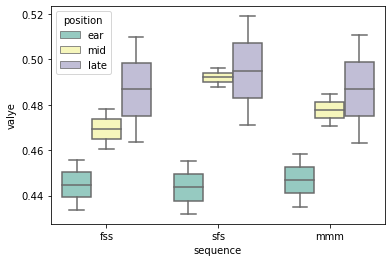

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(hue="position", y="valye", x="sequence", data=df, palette="Set3")
plt.show()

In [25]:
import pingouin as pg
res = pg.anova(dv='valye', between=['position', 'sequence'], 
                  data=df, detailed=True)
res

,Source,SS,DF,MS,F,p-unc,np2
0,position,0.006555,2,0.003278,6.653012,0.016834,0.596522
1,sequence,0.000308,2,0.000154,0.312178,0.739467,0.064872
2,position * sequence,0.000319,4,0.000080,0.161940,0.952419,0.067141
3,Residual,0.004434,9,0.000493,NaN,NaN,NaN


In [26]:
res = pg.rm_anova(dv='valye', within=['position', 'speed'], subject='subject', 
                  data=df, detailed=True)
res

C:\Users\Peter\anaconda3\lib\site-packages\pingouin\distribution.py:459: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.


,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,np2,eps
0,position,0.006498,2,2,0.003249,1.475277,0.403995,0.438499,0.596005,0.500000
1,speed,0.000020,2,2,0.000010,0.055697,0.947241,0.852456,0.052759,0.500000
2,position * speed,-0.000259,4,4,-0.000065,0.177963,0.938424,0.745858,0.151077,0.142857


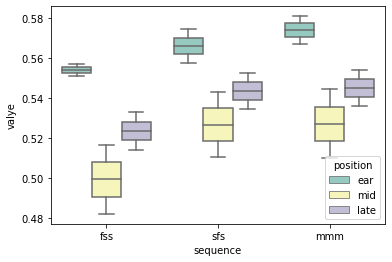

Interaction neuron:  0
Two way main effect neuron:  0


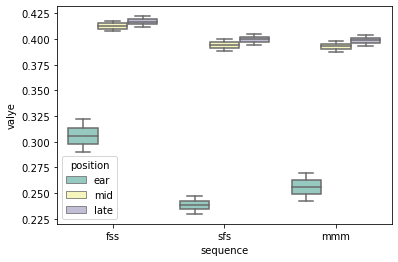

Interaction neuron:  3
Two way main effect neuron:  3
Two way main effect neuron:  5
Two way main effect neuron:  7


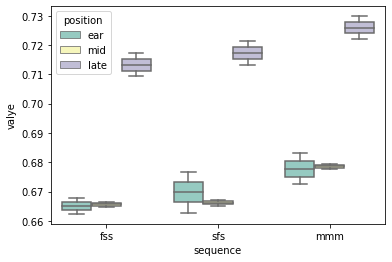

Interaction neuron:  8
Two way main effect neuron:  8


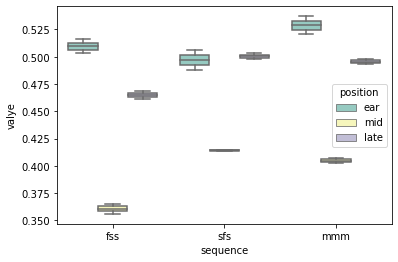

Interaction neuron:  9
Two way main effect neuron:  9


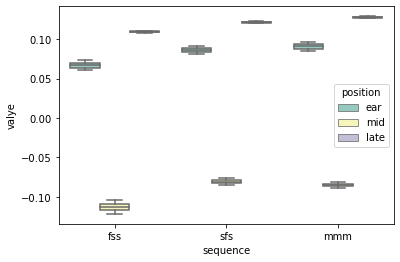

Interaction neuron:  11
Two way main effect neuron:  11


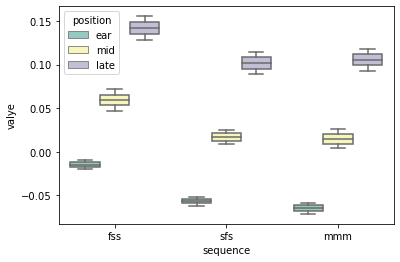

Interaction neuron:  13
Two way main effect neuron:  13


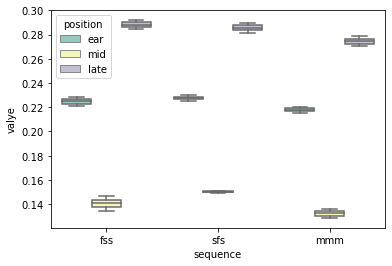

Interaction neuron:  14
Two way main effect neuron:  14


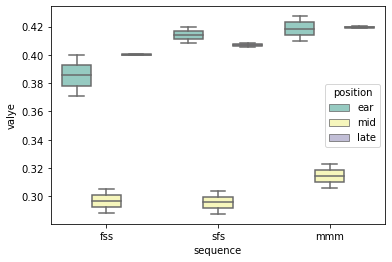

Interaction neuron:  15
Two way main effect neuron:  15


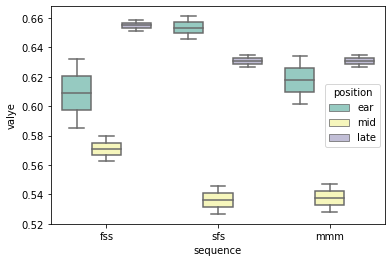

Interaction neuron:  16
Two way main effect neuron:  16


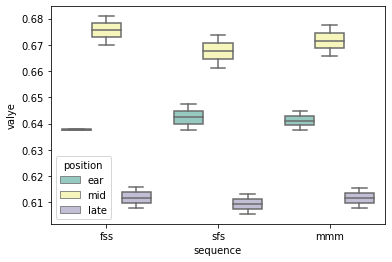

Interaction neuron:  18
Two way main effect neuron:  18


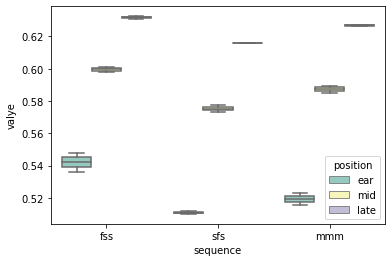

Interaction neuron:  20
Two way main effect neuron:  20


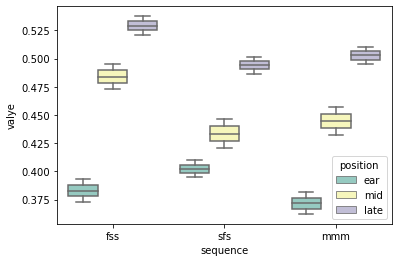

Interaction neuron:  23
Two way main effect neuron:  23


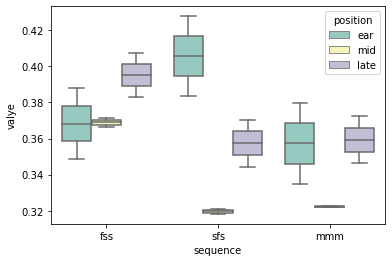

Interaction neuron:  28
Two way main effect neuron:  28


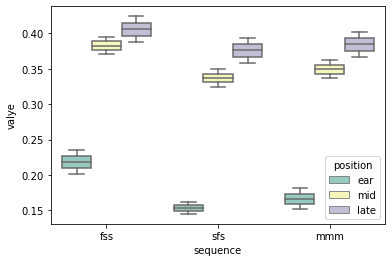

Interaction neuron:  31
Two way main effect neuron:  31


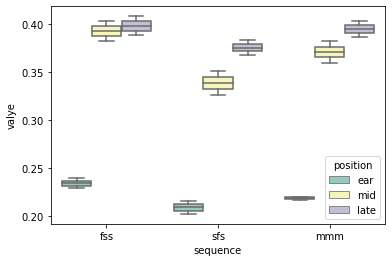

Interaction neuron:  37
Two way main effect neuron:  37


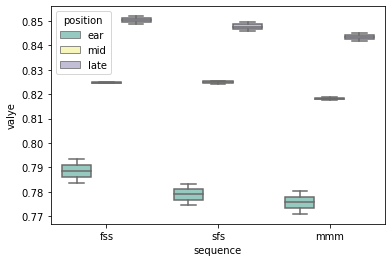

Interaction neuron:  39
Two way main effect neuron:  39
Two way main effect neuron:  45


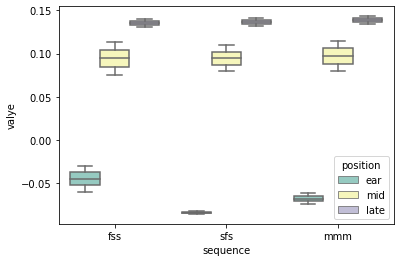

Interaction neuron:  47
Two way main effect neuron:  47


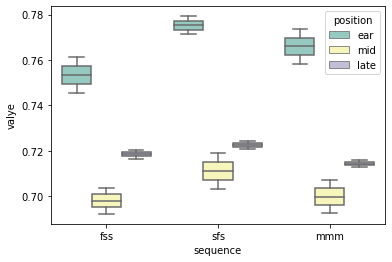

Interaction neuron:  48
Two way main effect neuron:  48


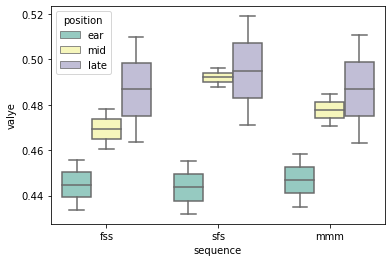

Interaction neuron:  50
Two way main effect neuron:  50
Two way main effect neuron:  51
Two way main effect neuron:  54


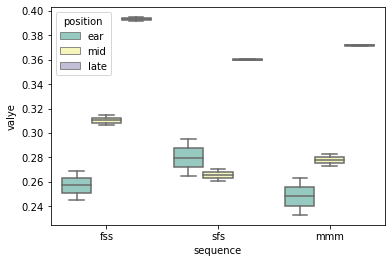

Interaction neuron:  61
Two way main effect neuron:  64
Two way main effect neuron:  67


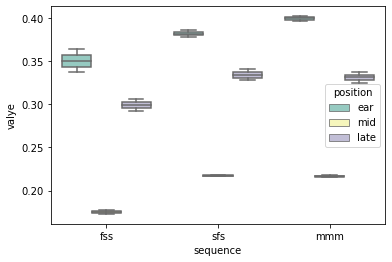

Interaction neuron:  68
Two way main effect neuron:  68


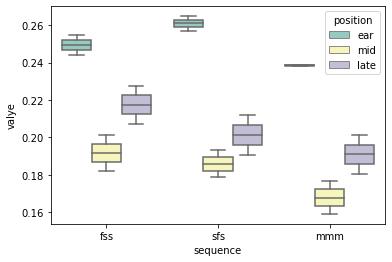

Interaction neuron:  69
Two way main effect neuron:  69


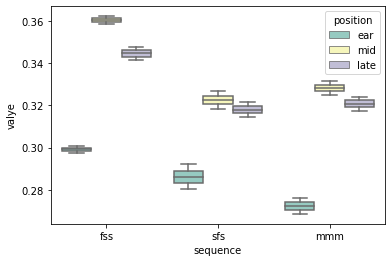

Interaction neuron:  72
Two way main effect neuron:  72


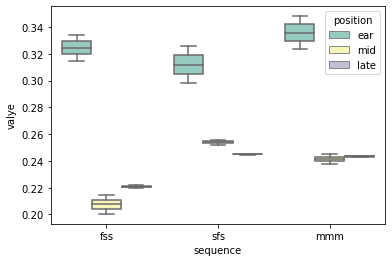

Interaction neuron:  74
Two way main effect neuron:  74


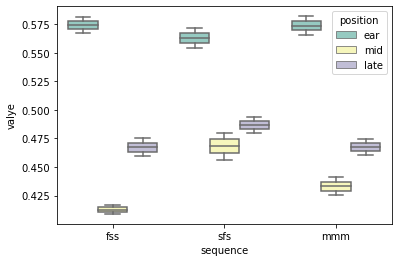

Interaction neuron:  79
Two way main effect neuron:  79
Two way main effect neuron:  83


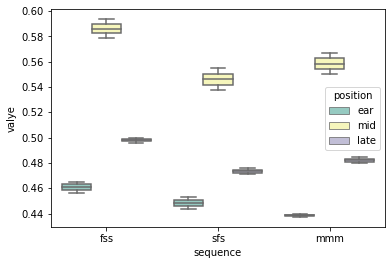

Interaction neuron:  89
Two way main effect neuron:  89


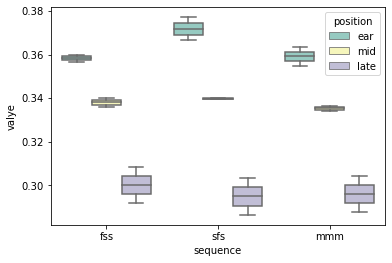

Interaction neuron:  90
Two way main effect neuron:  90
Two way main effect neuron:  94


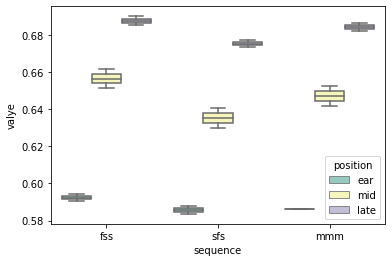

Interaction neuron:  96
Two way main effect neuron:  96


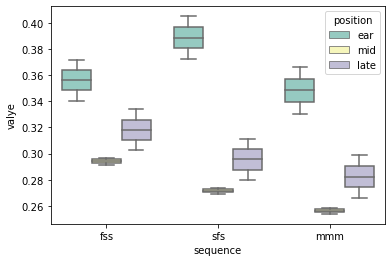

Interaction neuron:  97
Two way main effect neuron:  97


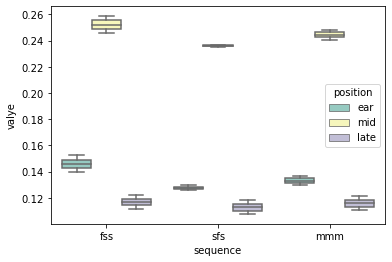

Interaction neuron:  102
Two way main effect neuron:  102


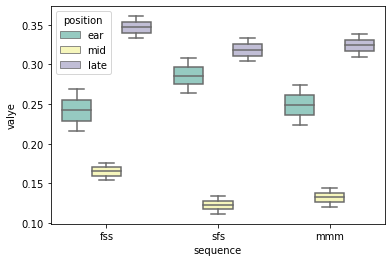

Interaction neuron:  105
Two way main effect neuron:  105
Two way main effect neuron:  106


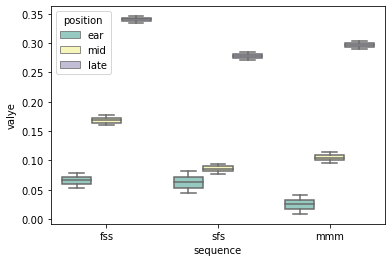

Interaction neuron:  109
Two way main effect neuron:  109


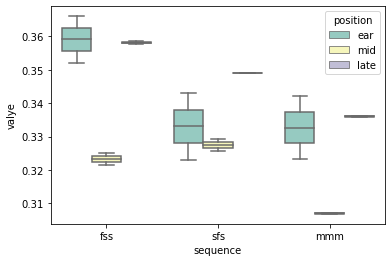

Interaction neuron:  111
Two way main effect neuron:  111


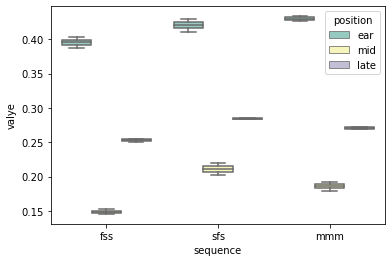

Interaction neuron:  112
Two way main effect neuron:  112


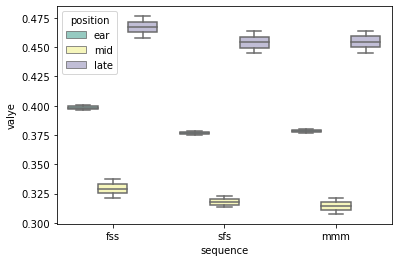

Interaction neuron:  120
Two way main effect neuron:  120


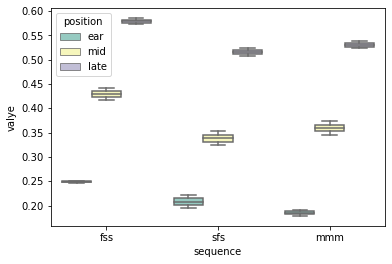

Interaction neuron:  125
Two way main effect neuron:  125
Two way main effect neuron:  128


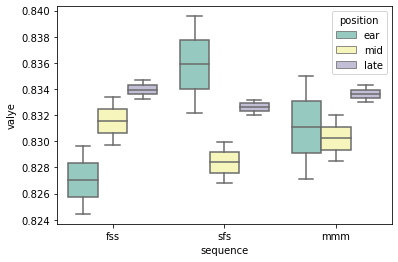

Interaction neuron:  134
Two way main effect neuron:  134


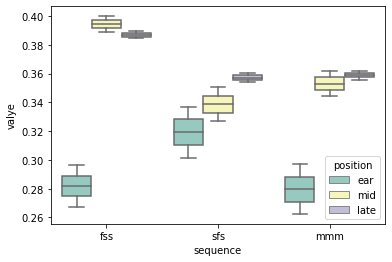

Interaction neuron:  137
Two way main effect neuron:  137


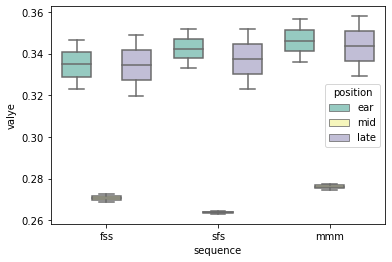

Interaction neuron:  138
Two way main effect neuron:  138


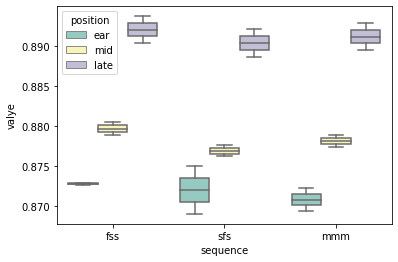

Interaction neuron:  139
Two way main effect neuron:  139


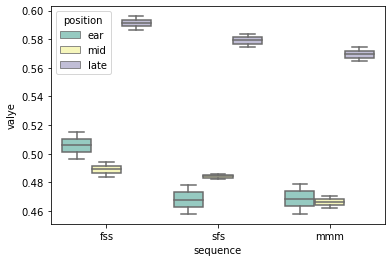

Interaction neuron:  140
Two way main effect neuron:  140


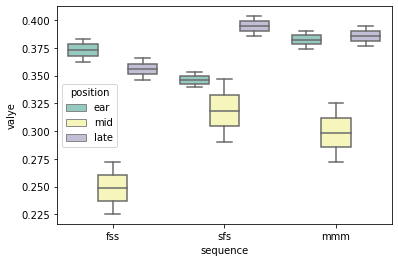

Interaction neuron:  142
Two way main effect neuron:  142


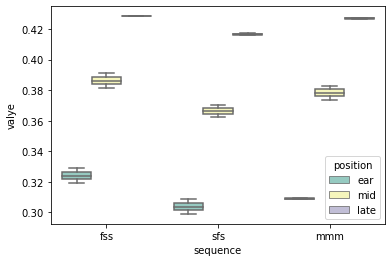

Interaction neuron:  145
Two way main effect neuron:  145


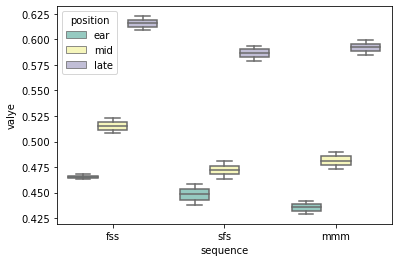

Interaction neuron:  148
Two way main effect neuron:  148


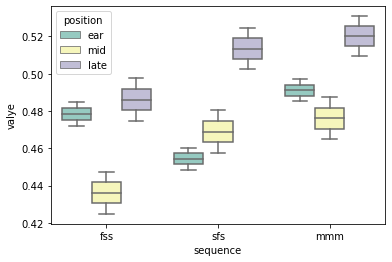

Interaction neuron:  149
Two way main effect neuron:  149


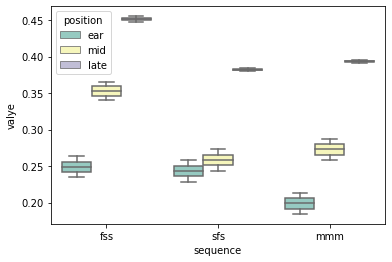

Interaction neuron:  152


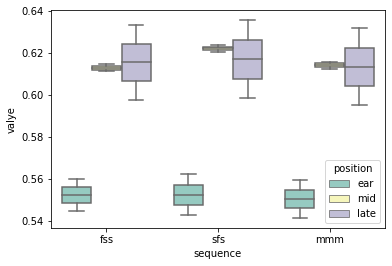

Interaction neuron:  153
Two way main effect neuron:  153
Two way main effect neuron:  159


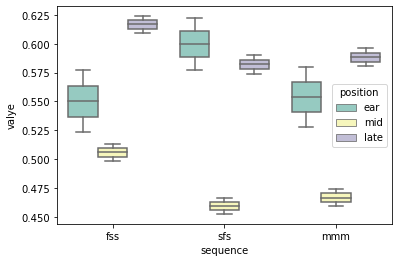

Interaction neuron:  160
Two way main effect neuron:  160
Two way main effect neuron:  163


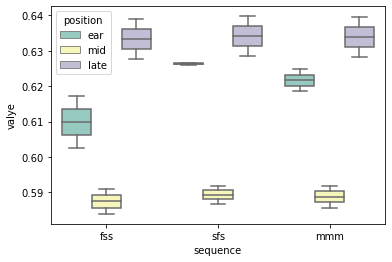

Interaction neuron:  166
Two way main effect neuron:  166


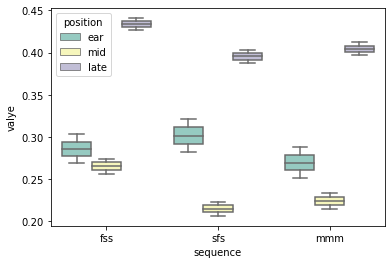

Interaction neuron:  167
Two way main effect neuron:  167


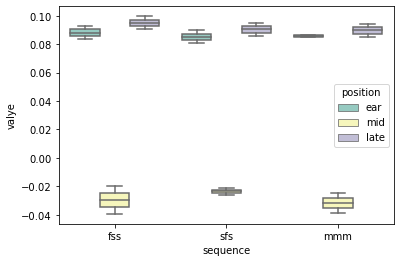

Interaction neuron:  168
Two way main effect neuron:  168


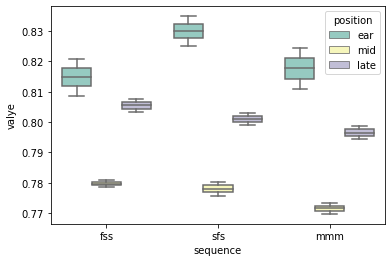

Interaction neuron:  170
Two way main effect neuron:  170


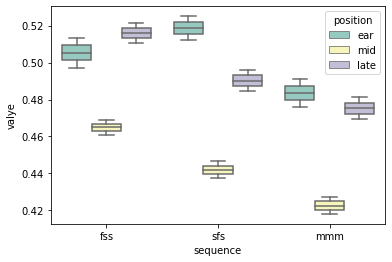

Interaction neuron:  175
Two way main effect neuron:  175


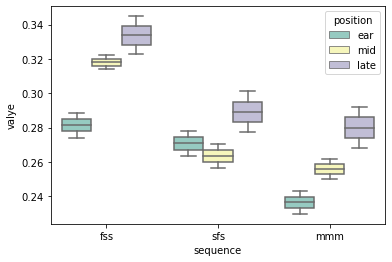

Interaction neuron:  176
Two way main effect neuron:  176


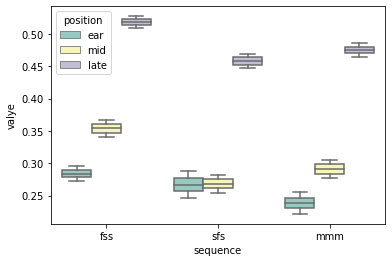

Interaction neuron:  177


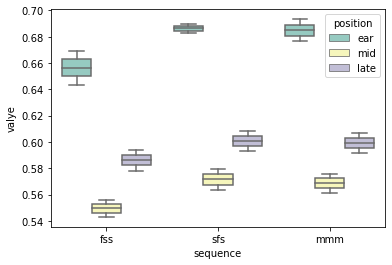

Interaction neuron:  178
Two way main effect neuron:  178


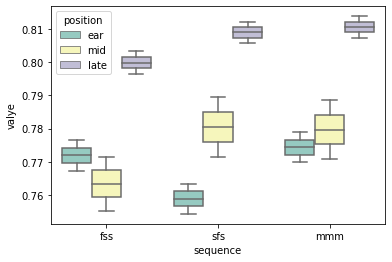

Interaction neuron:  180
Two way main effect neuron:  180
Two way main effect neuron:  182


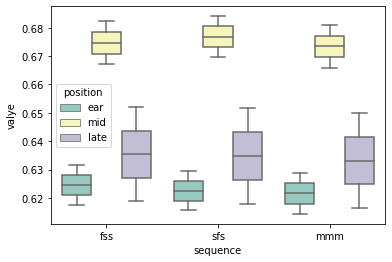

Interaction neuron:  184
Two way main effect neuron:  184


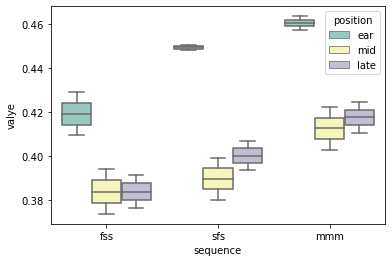

Interaction neuron:  186
Two way main effect neuron:  186


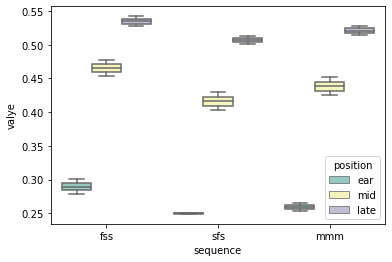

Interaction neuron:  188
Two way main effect neuron:  188


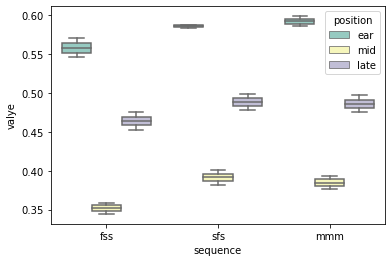

Interaction neuron:  194
Two way main effect neuron:  194


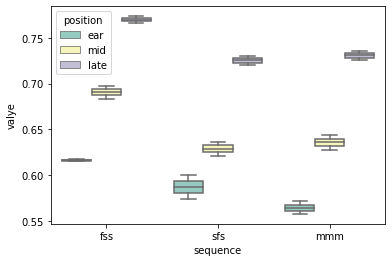

Interaction neuron:  196
Two way main effect neuron:  196


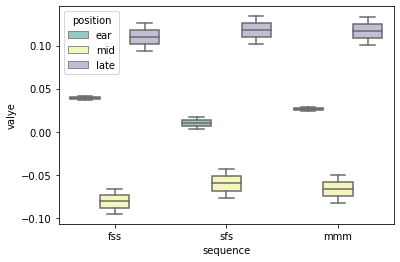

Interaction neuron:  200
Two way main effect neuron:  200
Two way main effect neuron:  201


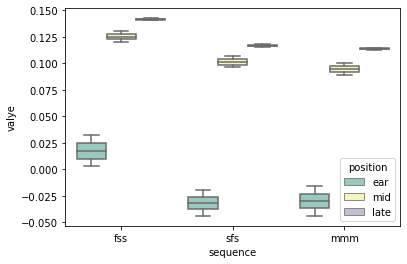

Interaction neuron:  204
Two way main effect neuron:  204


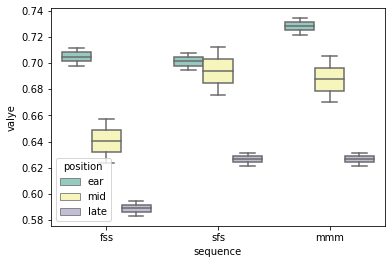

Interaction neuron:  205
Two way main effect neuron:  205


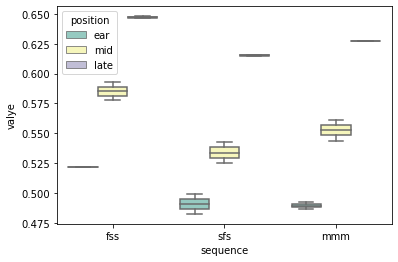

Interaction neuron:  207
Two way main effect neuron:  207
Two way main effect neuron:  208
Two way main effect neuron:  209


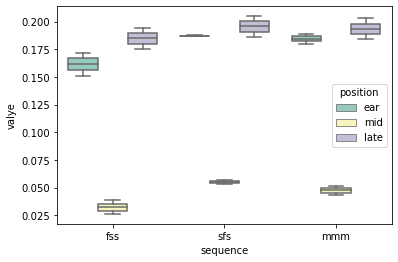

Interaction neuron:  210
Two way main effect neuron:  210


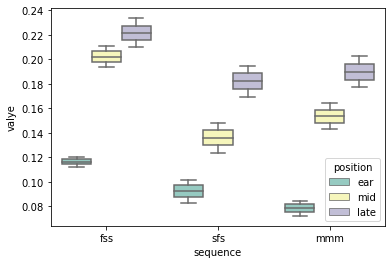

Interaction neuron:  213


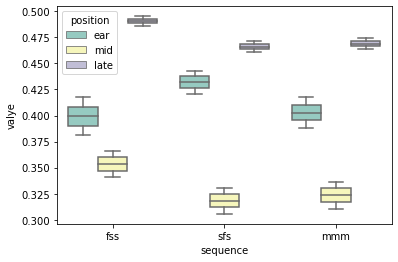

Interaction neuron:  216
Two way main effect neuron:  216
Two way main effect neuron:  217


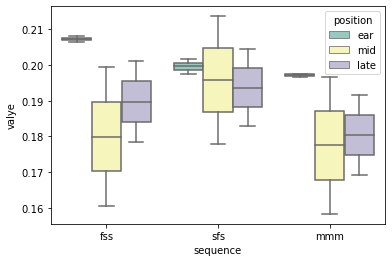

Interaction neuron:  218
Two way main effect neuron:  218


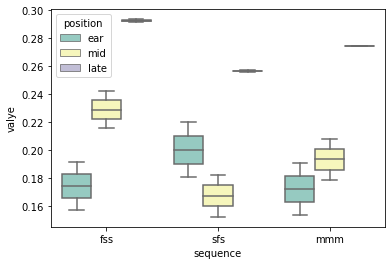

Interaction neuron:  222


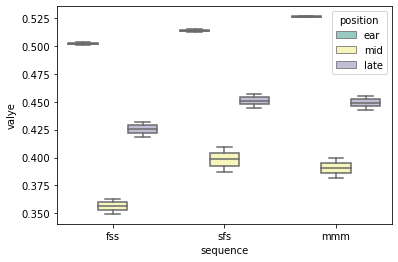

Interaction neuron:  224
Two way main effect neuron:  224
Two way main effect neuron:  228


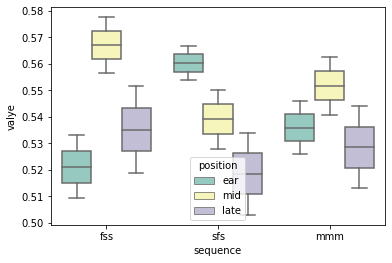

Interaction neuron:  229
Two way main effect neuron:  229


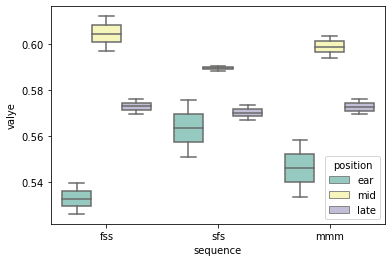

Interaction neuron:  230
Two way main effect neuron:  230


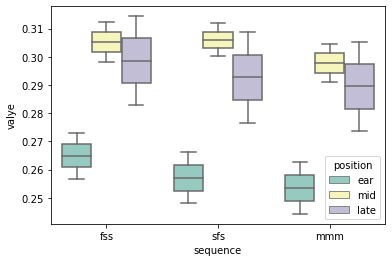

Interaction neuron:  231
Two way main effect neuron:  231


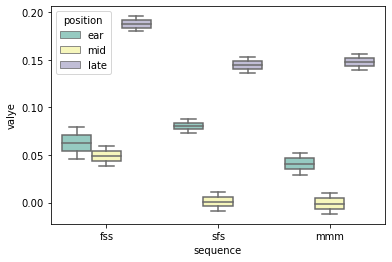

Interaction neuron:  232
Two way main effect neuron:  232


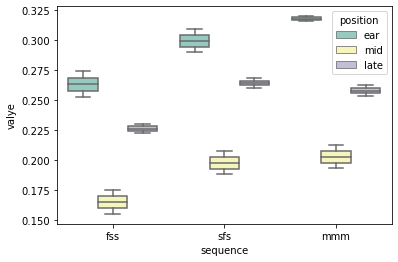

Interaction neuron:  233
Two way main effect neuron:  233


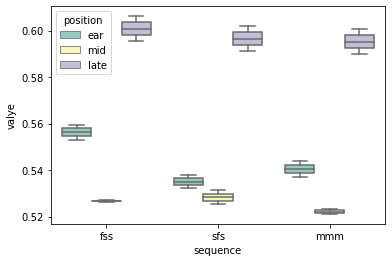

Interaction neuron:  234
Two way main effect neuron:  234


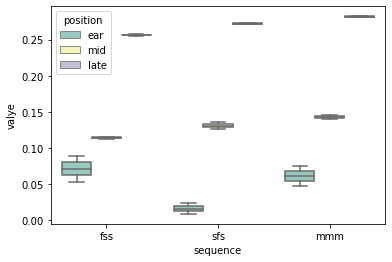

Interaction neuron:  235
Two way main effect neuron:  235


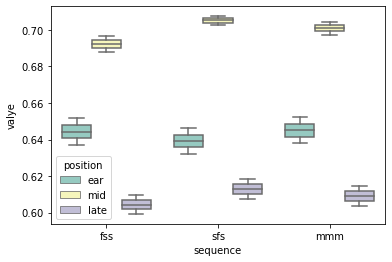

Interaction neuron:  239
Two way main effect neuron:  239


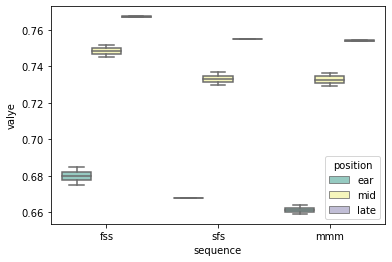

Interaction neuron:  245
Two way main effect neuron:  245


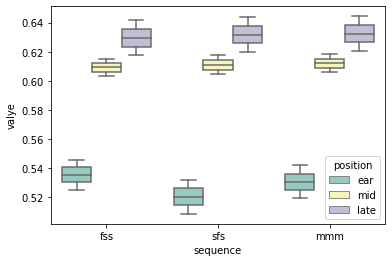

Interaction neuron:  247
Two way main effect neuron:  247


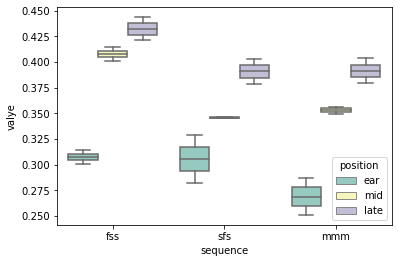

Interaction neuron:  248
Two way main effect neuron:  248


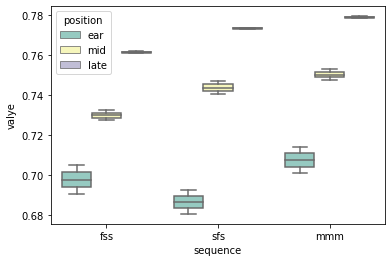

Interaction neuron:  253
Two way main effect neuron:  253


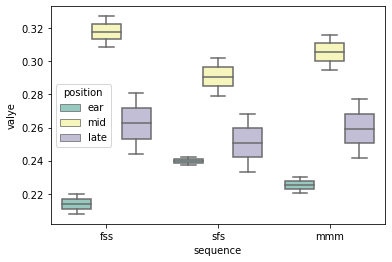

Interaction neuron:  255
Two way main effect neuron:  255


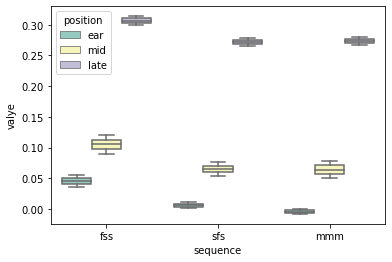

Interaction neuron:  256
Two way main effect neuron:  256


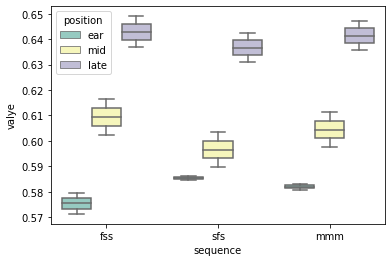

Interaction neuron:  257
Two way main effect neuron:  257


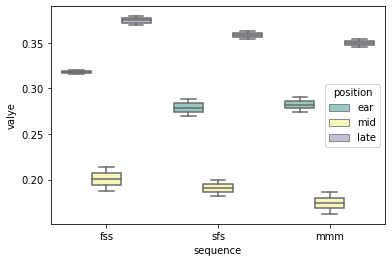

Interaction neuron:  258
Two way main effect neuron:  258


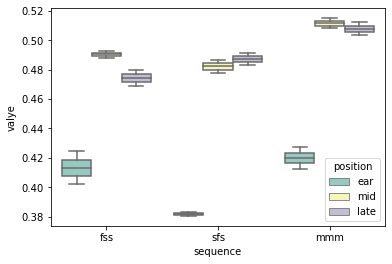

Interaction neuron:  259
Two way main effect neuron:  259


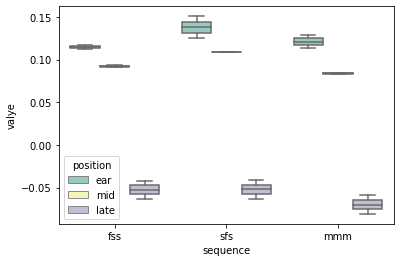

Interaction neuron:  264
Two way main effect neuron:  264
Two way main effect neuron:  275


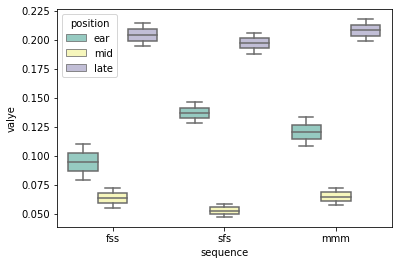

Interaction neuron:  276
Two way main effect neuron:  276
Two way main effect neuron:  277
Two way main effect neuron:  278


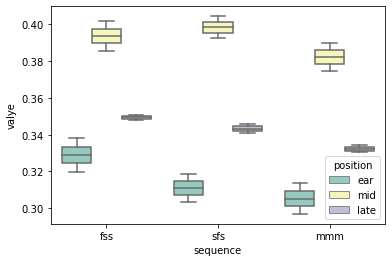

Interaction neuron:  279
Two way main effect neuron:  279


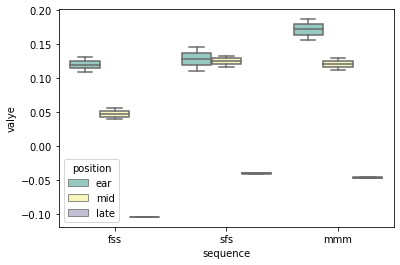

Interaction neuron:  281
Two way main effect neuron:  281


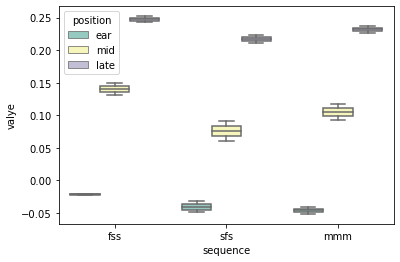

Interaction neuron:  282
Two way main effect neuron:  282


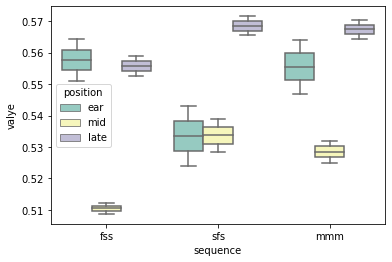

Interaction neuron:  285
Two way main effect neuron:  285


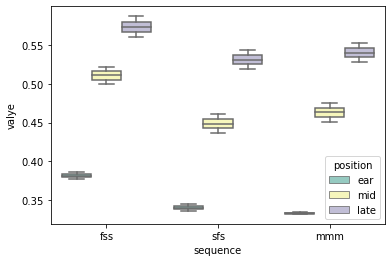

Interaction neuron:  286
Two way main effect neuron:  286


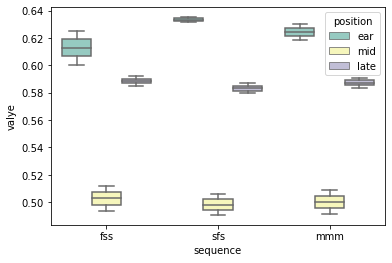

Interaction neuron:  287
Two way main effect neuron:  287


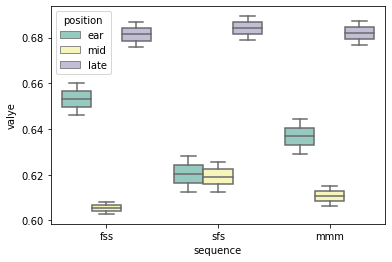

Interaction neuron:  288
Two way main effect neuron:  288


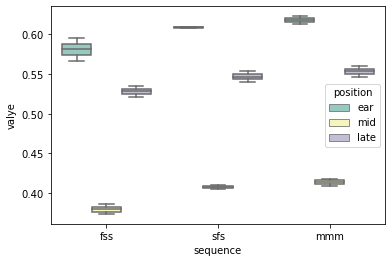

Interaction neuron:  289
Two way main effect neuron:  289


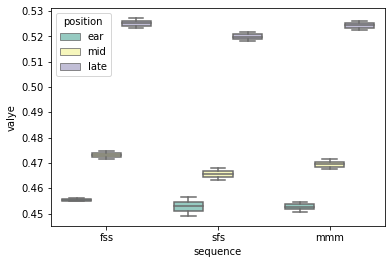

Interaction neuron:  292
Two way main effect neuron:  292


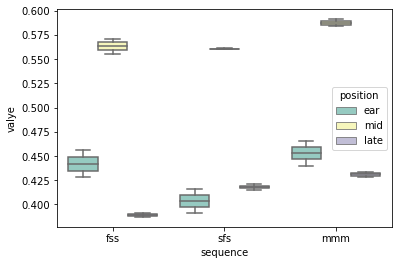

Interaction neuron:  293
Two way main effect neuron:  293


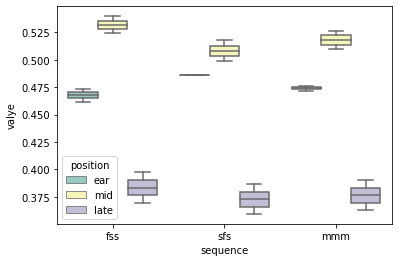

Interaction neuron:  297
Two way main effect neuron:  297


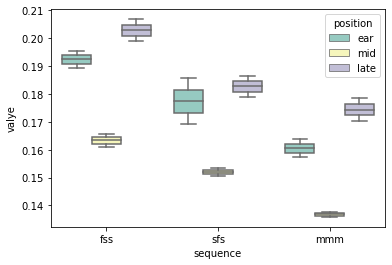

Interaction neuron:  303
Two way main effect neuron:  303


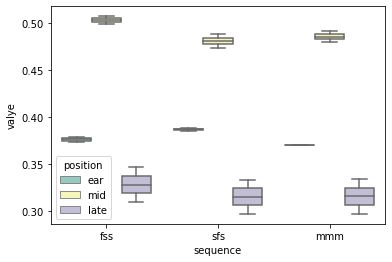

Interaction neuron:  304
Two way main effect neuron:  304


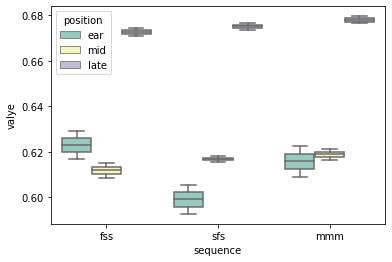

Interaction neuron:  306
Two way main effect neuron:  306


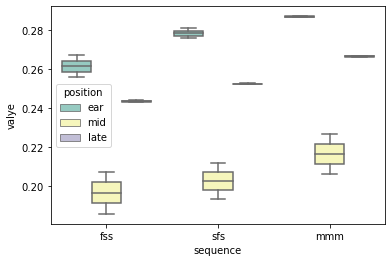

Interaction neuron:  307
Two way main effect neuron:  307


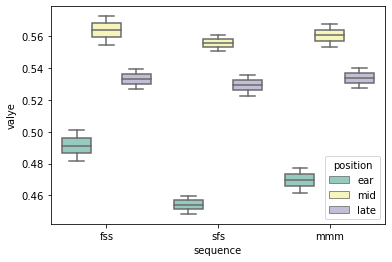

Interaction neuron:  309
Two way main effect neuron:  309


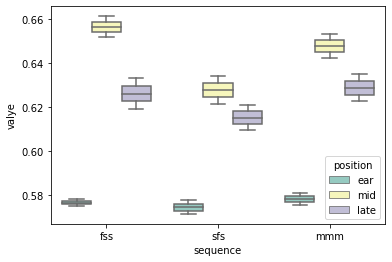

Interaction neuron:  311
Two way main effect neuron:  311
Two way main effect neuron:  312


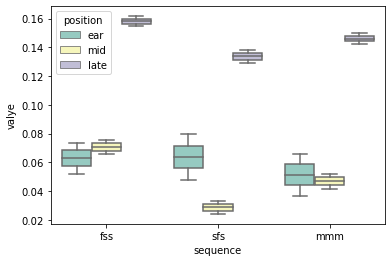

Interaction neuron:  314
Two way main effect neuron:  314


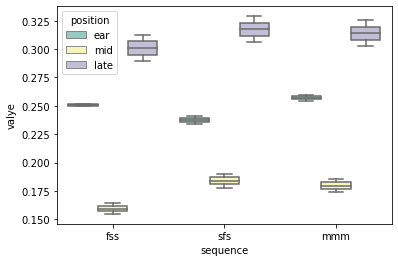

Interaction neuron:  319
Two way main effect neuron:  319


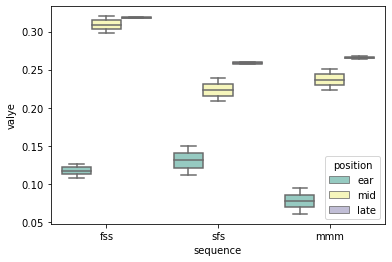

Interaction neuron:  324
Two way main effect neuron:  324


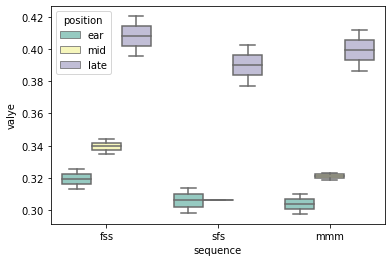

Interaction neuron:  325
Two way main effect neuron:  325


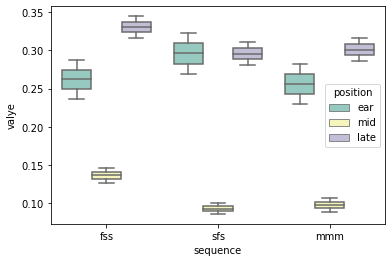

Interaction neuron:  326
Two way main effect neuron:  326
Two way main effect neuron:  333


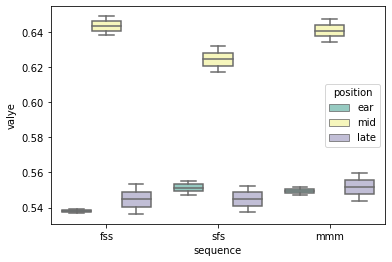

Interaction neuron:  334
Two way main effect neuron:  334
Two way main effect neuron:  335


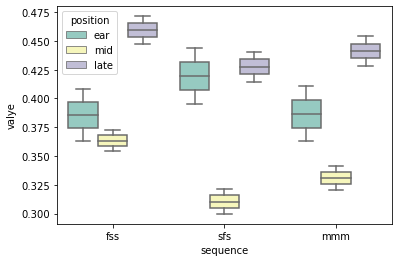

Interaction neuron:  336
Two way main effect neuron:  336


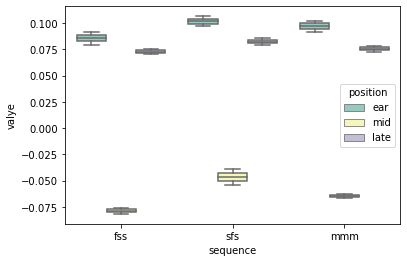

Interaction neuron:  339
Two way main effect neuron:  339


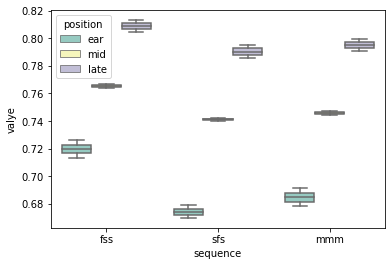

Interaction neuron:  342
Two way main effect neuron:  342


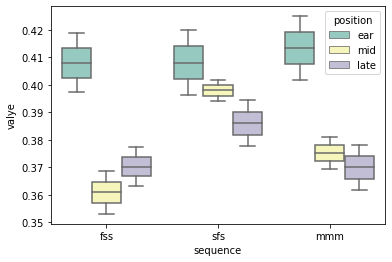

Interaction neuron:  343
Two way main effect neuron:  343


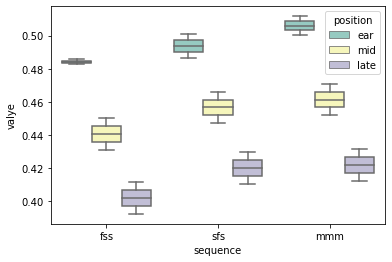

Interaction neuron:  344
Two way main effect neuron:  344
Two way main effect neuron:  345


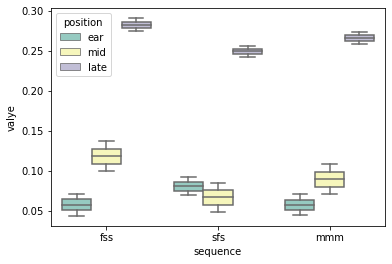

Interaction neuron:  346
Two way main effect neuron:  346


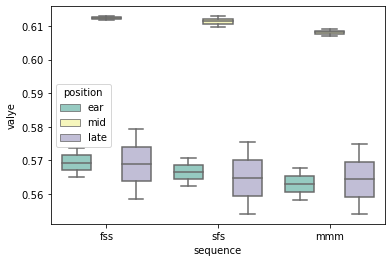

Interaction neuron:  347
Two way main effect neuron:  347


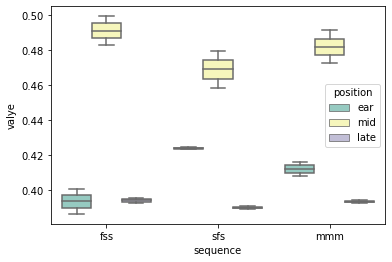

Interaction neuron:  349
Two way main effect neuron:  349


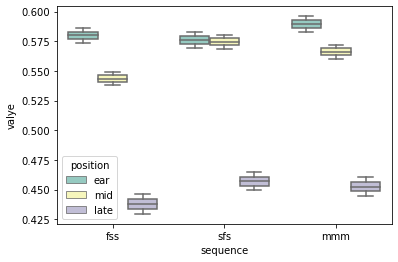

Interaction neuron:  350
Two way main effect neuron:  350


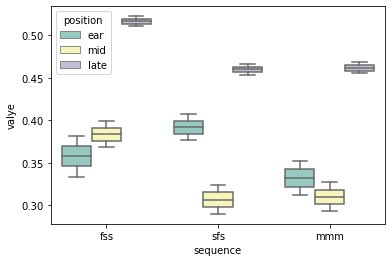

Interaction neuron:  351


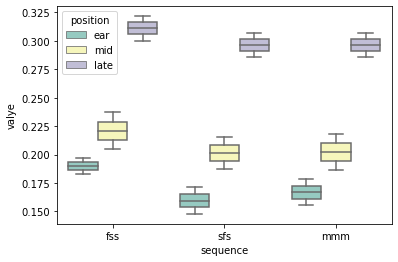

Interaction neuron:  352


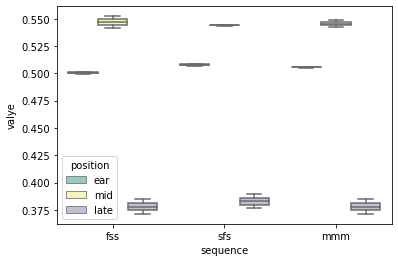

Interaction neuron:  354
Two way main effect neuron:  354


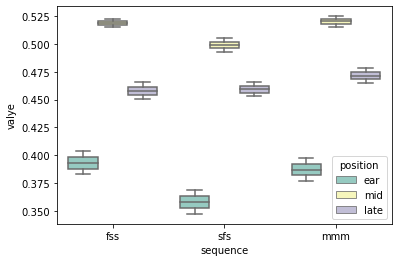

Interaction neuron:  356
Two way main effect neuron:  356


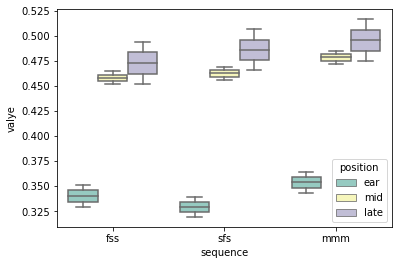

Interaction neuron:  357
Two way main effect neuron:  357


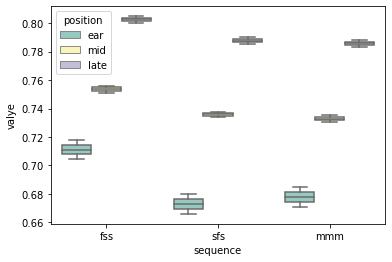

Interaction neuron:  358
Two way main effect neuron:  358


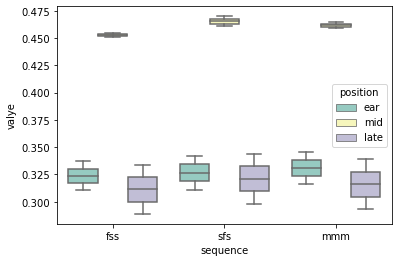

Interaction neuron:  359
Two way main effect neuron:  359


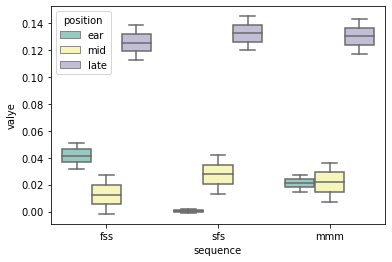

Interaction neuron:  360
Two way main effect neuron:  360


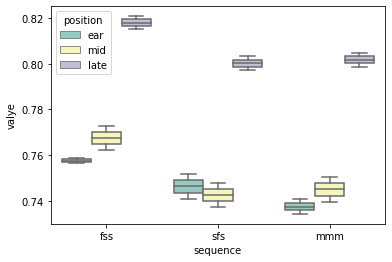

Interaction neuron:  361
Two way main effect neuron:  361


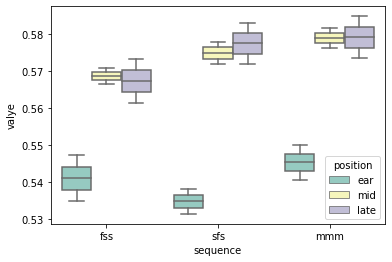

Interaction neuron:  362
Two way main effect neuron:  362


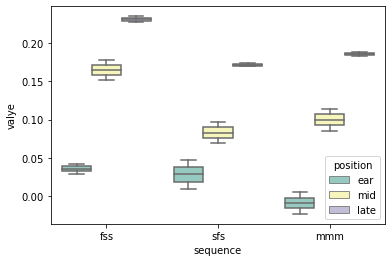

Interaction neuron:  374
Two way main effect neuron:  374


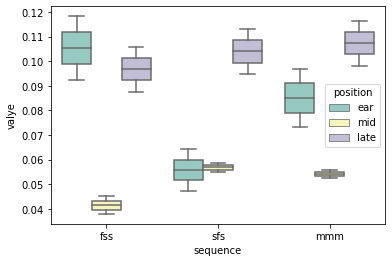

Interaction neuron:  375
Two way main effect neuron:  375


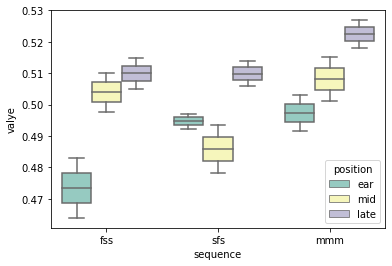

Interaction neuron:  376
Two way main effect neuron:  376


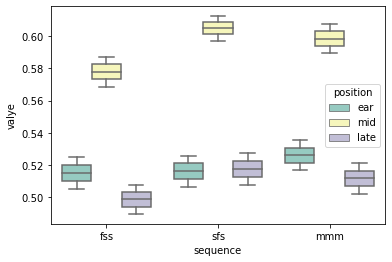

Interaction neuron:  378
Two way main effect neuron:  378


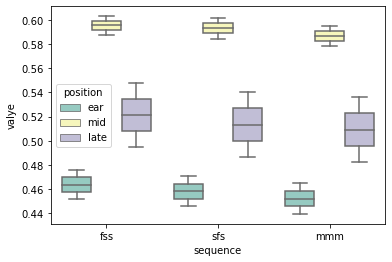

Interaction neuron:  379
Two way main effect neuron:  379


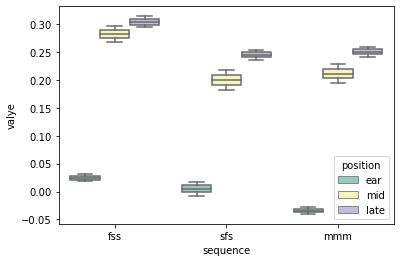

Interaction neuron:  380
Two way main effect neuron:  380


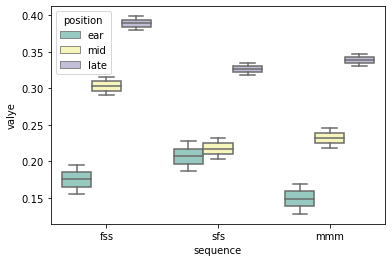

Interaction neuron:  384


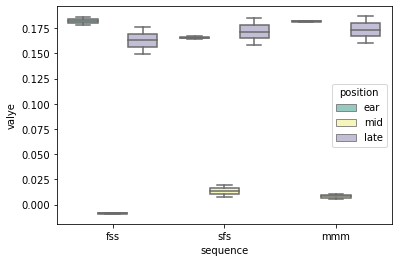

Interaction neuron:  393
Two way main effect neuron:  393


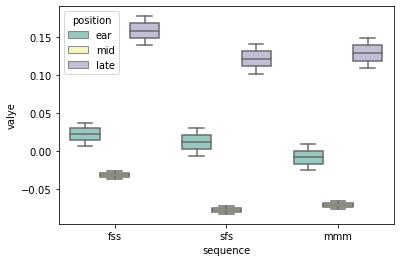

Interaction neuron:  395
Two way main effect neuron:  395


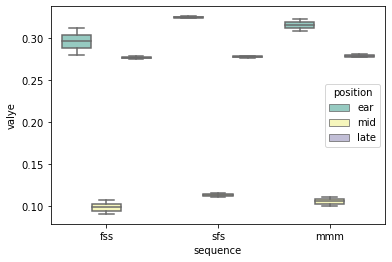

Interaction neuron:  396
Two way main effect neuron:  396
Two way main effect neuron:  397
p-unc 0.001
position effect    :  376
sequence effec    t:  352
pos*seq interaction:  294


In [27]:
p_count=0
s_count=0
ps_count=0
sign = 0.001
factor ='p-unc'#'p-GG-corr'#
for neuron in range(400):
    for i in range(18):
        df.loc[i,'valye']=stat_data[neuron,i]
    #print("Neuron", neuron)
        
#    res = pg.rm_anova(dv='valye', within=['position', 'sequence'], subject='subject', 
#                  data=df, detailed=True)
    res = pg.anova(dv='valye', between=['position', 'speed'], 
                  data=df, detailed=True)
    if res.loc[0,factor] < sign:
        p_count = p_count +1

    if res.loc[1,factor] < sign:
        s_count = s_count +1

    if res.loc[2,factor] < sign:
        ps_count = ps_count +1   
        if  np.mean(stat_data[neuron,:]) > 0:
            sns.boxplot(hue="position", y="valye", x="sequence", data=df, palette="Set3")
            plt.show()
            print("Interaction neuron: ", neuron)

    if res.loc[0,factor] < sign and res.loc[1,factor] < sign and np.mean(stat_data[neuron,:]) > 0:
        print("Two way main effect neuron: ", neuron)
print(factor, sign)
print("position effect    : ",p_count)       
print("sequence effec    t: ",s_count)       
print("pos*seq interaction: ",ps_count)    

In [28]:
#now same thing for LI
stat_data_li=np.zeros((256,18))

In [29]:
#OK NOW WE FORMAT THE DATA TO GO INTO THE ANOVA
#inputAverageTesting1
# 8 6 8
#6 8 8
#create stats table: three columns
#early = 5#8 #7
#middle = 11#13#15
#late = 15#16#15

for i in range(len(inputAverageTesting2[1])):
    #12 columns: 2x2x3 type, rep, 5, 13, 21 for 'fss_0', 'fss_1', 'sfs_0', 'sfs_1'
    stat_data_li[i,0]=inputAverageTesting1[early,i]
    stat_data_li[i,1]=inputAverageTesting1[middle,i]    
    stat_data_li[i,2]=inputAverageTesting1[late,i]        
    stat_data_li[i,3]=inputAverageTesting1[early+delta,i]
    stat_data_li[i,4]=inputAverageTesting1[middle+delta,i]    
    stat_data_li[i,5]=inputAverageTesting1[late+delta,i]            

    stat_data_li[i,6]=inputAverageTesting2[early,i]
    stat_data_li[i,7]=inputAverageTesting2[middle,i]    
    stat_data_li[i,8]=inputAverageTesting2[late,i]        
    stat_data_li[i,9]=inputAverageTesting2[early+delta,i]
    stat_data_li[i,10]=inputAverageTesting2[middle+delta,i]    
    stat_data_li[i,11]=inputAverageTesting2[late+delta,i] 
    
    stat_data_li[i,12]=inputAverageTesting3[early,i]
    stat_data_li[i,13]=inputAverageTesting3[middle,i]    
    stat_data_li[i,14]=inputAverageTesting3[late,i]        
    stat_data_li[i,15]=inputAverageTesting3[early+delta,i]
    stat_data_li[i,16]=inputAverageTesting3[middle+delta,i]    
    stat_data_li[i,17]=inputAverageTesting3[late+delta,i]     

In [30]:
p_count=0
s_count=0
ps_count=0
sign = 0.001
factor ='p-unc'#'p-GG-corr'
for neuron in range(256):
    for i in range(18):
        df.loc[i,'valye']=stat_data_li[neuron,i]
    #print("Neuron", neuron)
        
#    res = pg.rm_anova(dv='valye', within=['position', 'sequence'], subject='subject', 
#                  data=df, detailed=True)

    res = pg.anova(dv='valye', between=['position', 'sequence'], 
                  data=df, detailed=True)
    if res.loc[0,factor] < sign:
        p_count = p_count +1

    if res.loc[1,factor] < sign:
        s_count = s_count +1

    if res.loc[2,factor] < sign:
        ps_count = ps_count +1   
        if  np.mean(stat_data_li[neuron,:]) > 0:
            sns.boxplot(hue="position", y="valye", x="sequence", data=df, palette="Set3")
            plt.show()
            print("Interaction neuron: ", neuron)


    if res.loc[0,factor] < sign and res.loc[1,factor] < sign and np.mean(stat_data_li[neuron,:]) > 0:
        print("Two way main effect neuron: ", neuron)
print(factor, sign)
print("position effect    : ",p_count)       
print("sequence effec    t: ",s_count)       
print("pos*seq interaction: ",ps_count)    

Two way main effect neuron:  0
Two way main effect neuron:  1
Two way main effect neuron:  2
Two way main effect neuron:  3
Two way main effect neuron:  4
Two way main effect neuron:  5
Two way main effect neuron:  6
Two way main effect neuron:  13
Two way main effect neuron:  16
Two way main effect neuron:  17
Two way main effect neuron:  18
Two way main effect neuron:  19
Two way main effect neuron:  20
Two way main effect neuron:  21
Two way main effect neuron:  28
Two way main effect neuron:  32
Two way main effect neuron:  33
Two way main effect neuron:  34
Two way main effect neuron:  35
Two way main effect neuron:  36
Two way main effect neuron:  43
Two way main effect neuron:  48
Two way main effect neuron:  49
Two way main effect neuron:  50
Two way main effect neuron:  51
Two way main effect neuron:  58
Two way main effect neuron:  64
Two way main effect neuron:  65
Two way main effect neuron:  66
Two way main effect neuron:  73
Two way main effect neuron:  80
Two way main ef

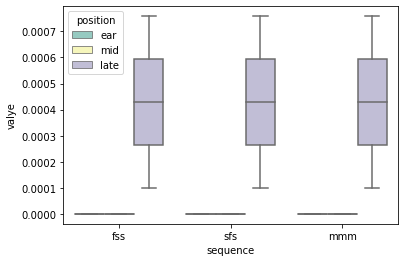

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(hue="position", y="valye", x="sequence", data=df, palette="Set3")
plt.show()

In [32]:
print(df)

   subject position sequence         valye speed
0       s1      ear      fss  1.169494e-29  fast
1       s1      mid      fss  8.014340e-14  slow
2       s1     late      fss  9.869167e-05  slow
3       s2      ear      fss  1.839815e-26  fast
4       s2      mid      fss  3.272918e-12  slow
5       s2     late      fss  7.581145e-04  slow
6       s1      ear      sfs  4.842891e-33  slow
7       s1      mid      sfs  1.525147e-15  fast
8       s1     late      sfs  9.869162e-05  slow
9       s2      ear      sfs  1.740189e-30  slow
10      s2      mid      sfs  2.793082e-13  fast
11      s2     late      sfs  7.581144e-04  slow
12      s1      ear      mmm  1.437639e-31   med
13      s1      mid      mmm  1.506998e-14   med
14      s1     late      mmm  9.869164e-05   med
15      s2      ear      mmm  1.001922e-28   med
16      s2      mid      mmm  1.151340e-12   med
17      s2     late      mmm  7.581144e-04   med
